In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import zipline

import os
os.chdir("/home/backstreet/use_zipline/asset_allocation")

from analysis import create_benchmark, analyze
from zipline.api import order_target_percent, symbol, schedule_function, date_rules, time_rules


In [3]:
def initialize(context):
    # ETFs and target weights for a balanced and hedged portfolio
    context.securities = {
        'SPY': 0.25, 
        'TLT': 0.3, 
        'IEF': 0.3, 
        'GLD': 0.075, 
        'DBC': 0.075
    }
    
    # Schedule rebalance for once a month
    schedule_function(rebalance, date_rules.month_start(), time_rules.market_open())
    
    # Set up a benchmark to measure against
    context.set_benchmark(symbol('SPY'))


def rebalance(context, data):
    # Loop through the securities
    for sec, weight in context.securities.items():
        sym = symbol(sec)
        
        # Check if we can trade
        if data.can_trade(sym):
            # Reset the weight
            order_target_percent(sym, weight) 


start = pd.Timestamp('2005-1-3', tz='utc')
end = pd.Timestamp('2020-10-26', tz='utc')


# Fire off backtest
result = zipline.run_algorithm(
    start=start, # Set start
    end=end,  # Set end
    initialize=initialize, # Define startup function
    capital_base=100000, # Set initial capital
    data_frequency = 'daily',  # Set data frequency
    bundle='custom-bundle' ) # Select bundle

print("Ready to analyze result.")


Ready to analyze result.


In [4]:
# Create a benchmark file for Pyfolio
bench_df = pd.read_csv('../prepare_custom_bundle/data/bars_adj/SPY.csv')
bench_df['return'] = bench_df.close_adj.pct_change()
bench_df.to_csv('SPY.csv', columns=['date','return'], index=False)

In [5]:
# Create a benchmark dataframe
bench_series = create_benchmark('SPY')

In [6]:
# Filter for the dates in returns to line up the graphs - normalize cleans up the dates
result.index = result.index.normalize() # to set the time to 00:00:00
bench_series = bench_series[bench_series.index.isin(result.index)]
bench_series

date
2005-01-03 00:00:00+00:00         NaN
2005-01-04 00:00:00+00:00   -0.012219
2005-01-05 00:00:00+00:00   -0.006901
2005-01-06 00:00:00+00:00    0.005084
2005-01-07 00:00:00+00:00   -0.001433
2005-01-10 00:00:00+00:00    0.004728
2005-01-11 00:00:00+00:00   -0.006891
2005-01-12 00:00:00+00:00    0.003300
2005-01-13 00:00:00+00:00   -0.008012
2005-01-14 00:00:00+00:00    0.005271
2005-01-18 00:00:00+00:00    0.010403
2005-01-19 00:00:00+00:00   -0.010463
2005-01-20 00:00:00+00:00   -0.006090
2005-01-21 00:00:00+00:00   -0.006128
2005-01-24 00:00:00+00:00   -0.001970
2005-01-25 00:00:00+00:00    0.002831
2005-01-26 00:00:00+00:00    0.002995
2005-01-27 00:00:00+00:00    0.001706
2005-01-28 00:00:00+00:00    0.000000
2005-01-31 00:00:00+00:00    0.006216
2005-02-01 00:00:00+00:00    0.006347
2005-02-02 00:00:00+00:00    0.003027
2005-02-03 00:00:00+00:00   -0.001341
2005-02-04 00:00:00+00:00    0.009403
2005-02-07 00:00:00+00:00   -0.001331
2005-02-08 00:00:00+00:00    0.001166
2005-02

Start date,2005-01-03
End date,2020-10-26
Total months,189
,Backtest
Annual return,4.7%
Cumulative returns,107.1%
Annual volatility,6.7%
Sharpe ratio,0.73
Calmar ratio,0.30
Stability,0.94
Max drawdown,-15.6%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,15.56,2008-03-18,2009-03-03,2010-08-05,623
1,12.06,2020-03-06,2020-03-18,2020-05-20,54
2,8.60,2015-02-02,2016-01-11,2016-06-08,353
3,7.97,2016-07-08,2016-12-16,2017-11-28,363
4,7.69,2013-05-02,2013-08-21,2014-05-28,280


Stress Events,mean,min,max
Lehman,-0.05%,-0.86%,0.61%
US downgrade/European Debt Crisis,0.19%,-1.29%,1.43%
Fukushima,0.07%,-0.46%,0.82%
EZB IR Event,-0.02%,-0.82%,0.58%
Aug07,0.05%,-0.75%,0.64%
Mar08,-0.02%,-0.71%,0.90%
Sept08,-0.11%,-0.86%,0.61%
2009Q1,-0.29%,-1.77%,0.90%
2009Q2,0.07%,-1.35%,3.04%
Flash Crash,-0.02%,-0.88%,0.56%


Top 10 long positions of all time,max
sid,
TLT,34.24%
IEF,33.30%
SPY,28.94%
GLD,8.64%
DBC,8.61%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
TLT,34.24%
IEF,33.30%
SPY,28.94%
GLD,8.64%
DBC,8.61%


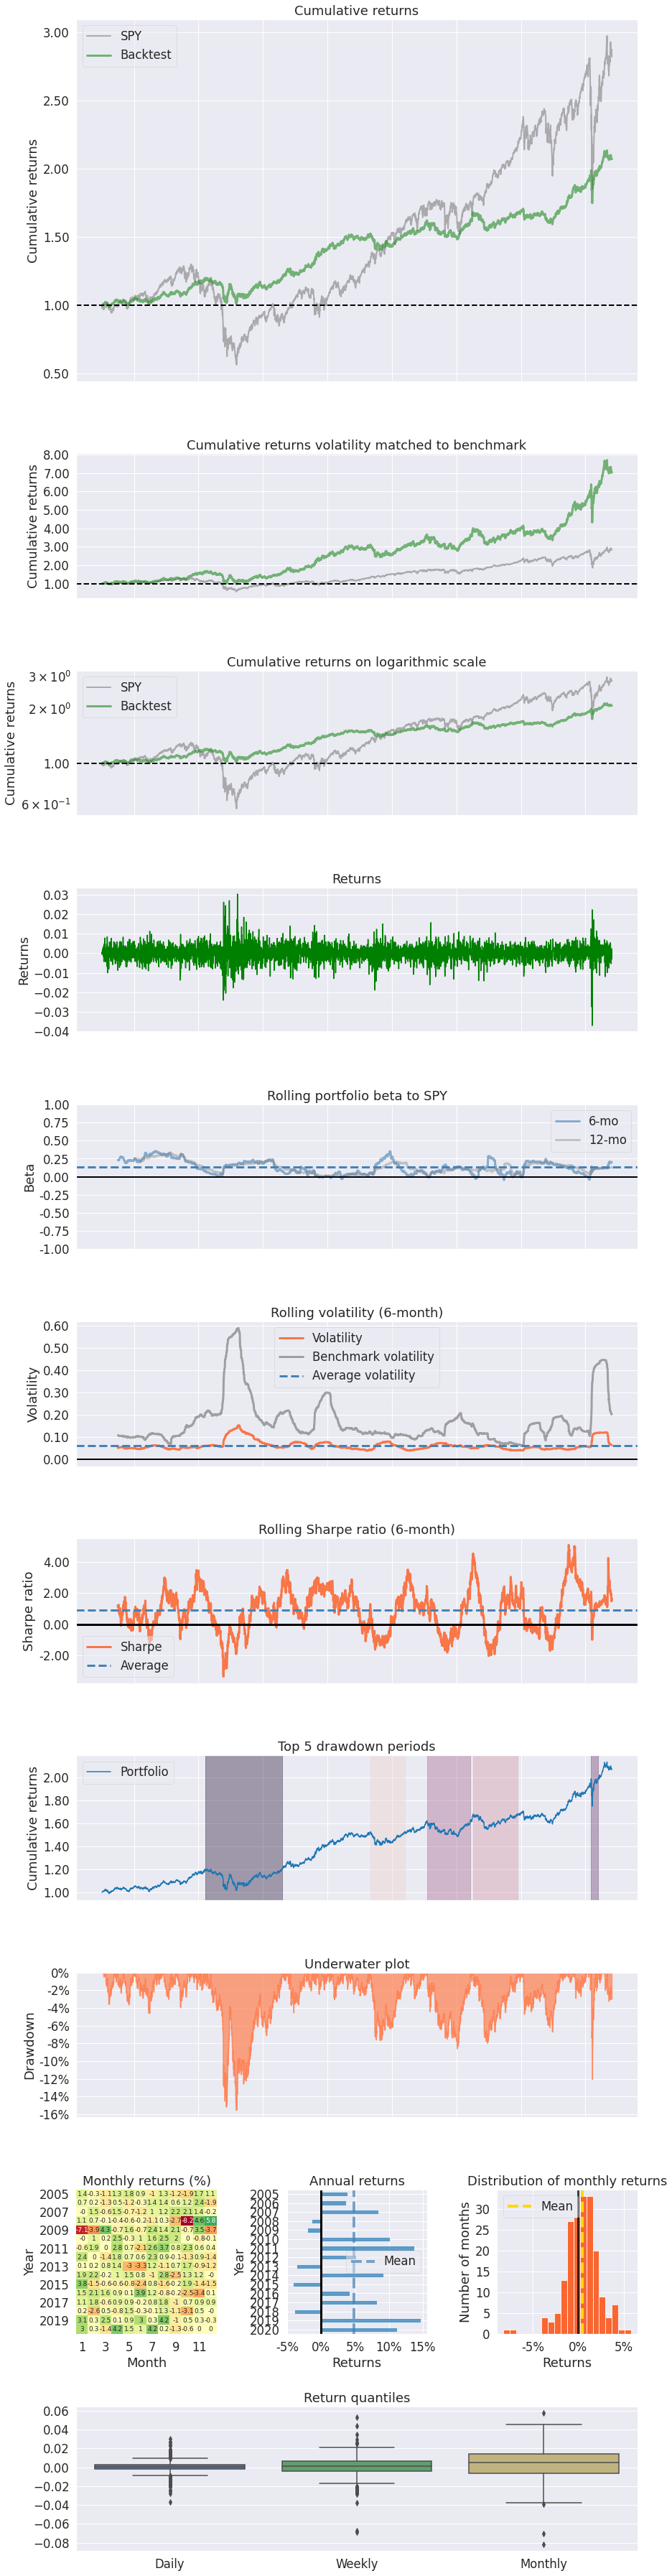

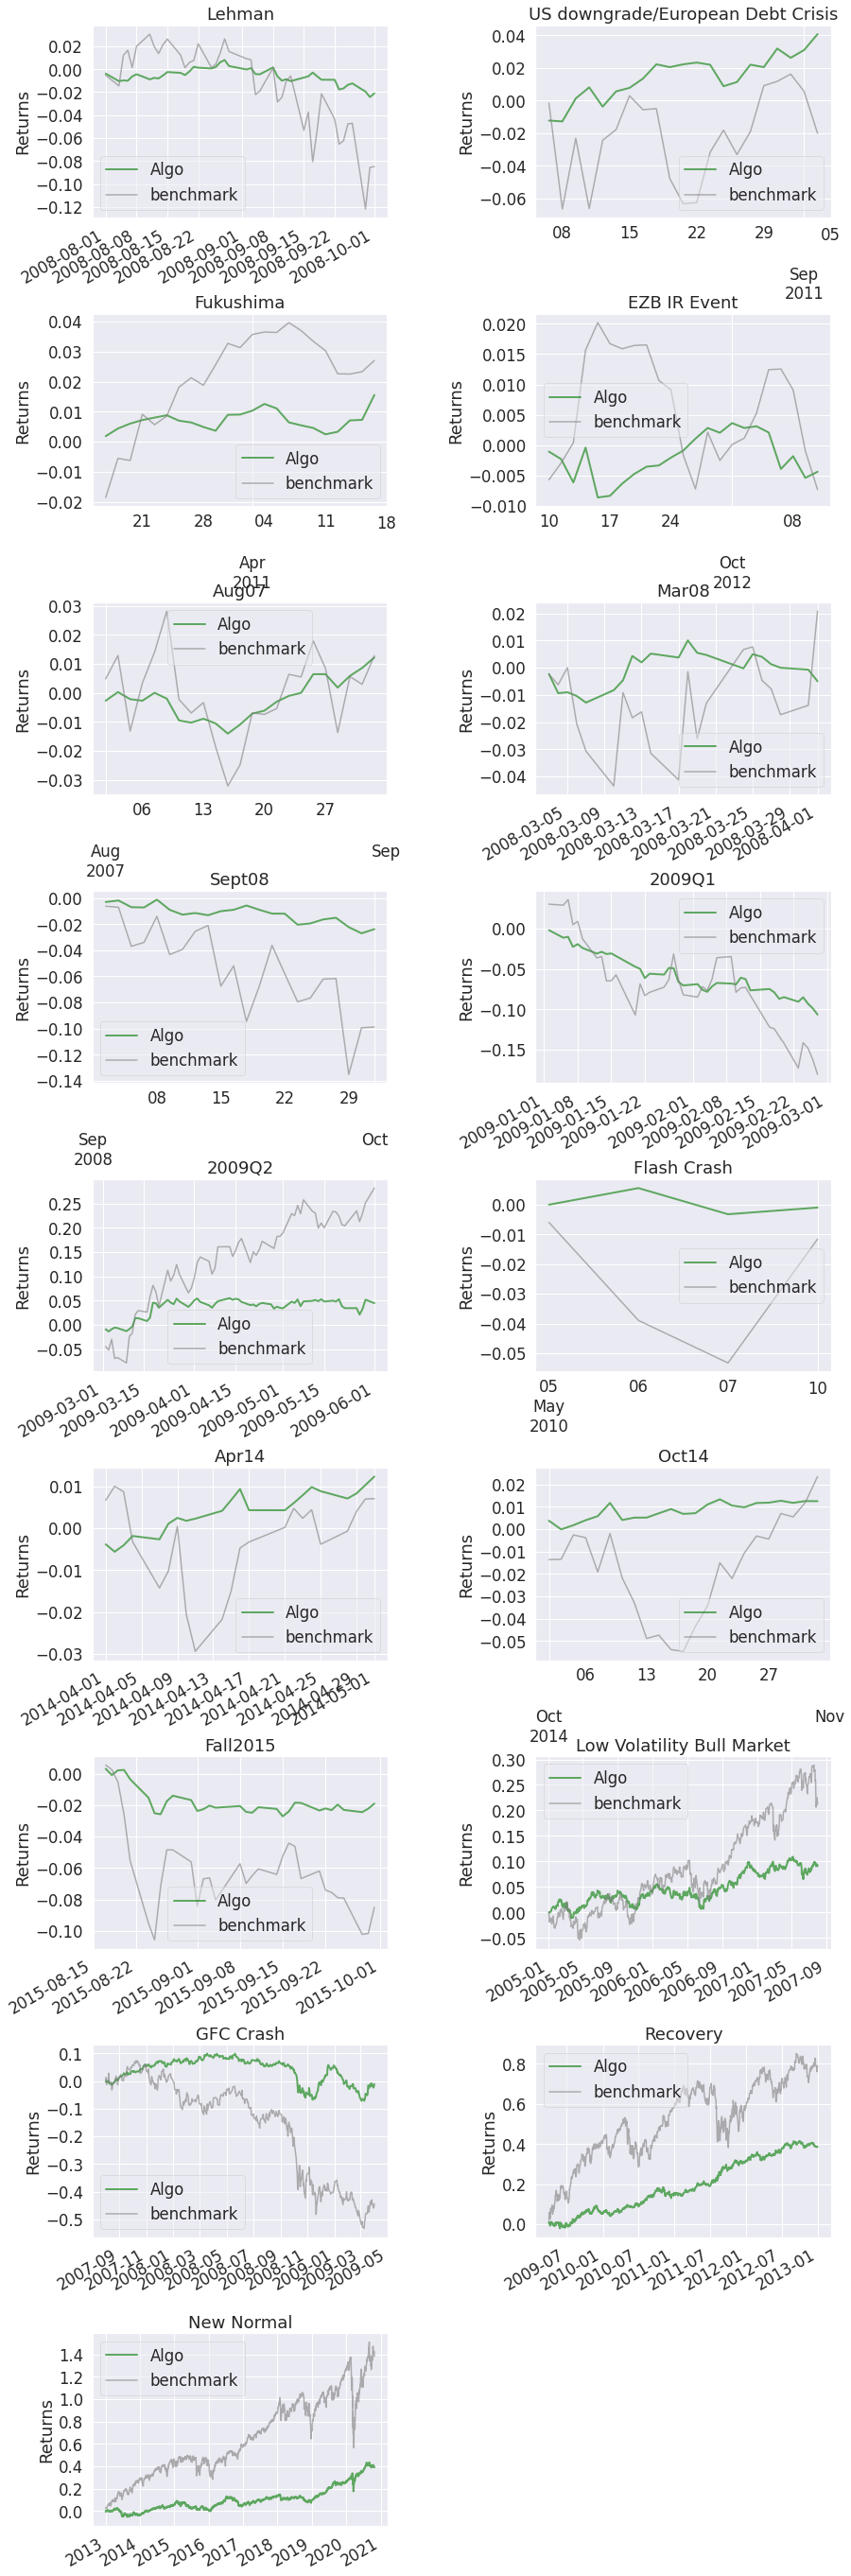

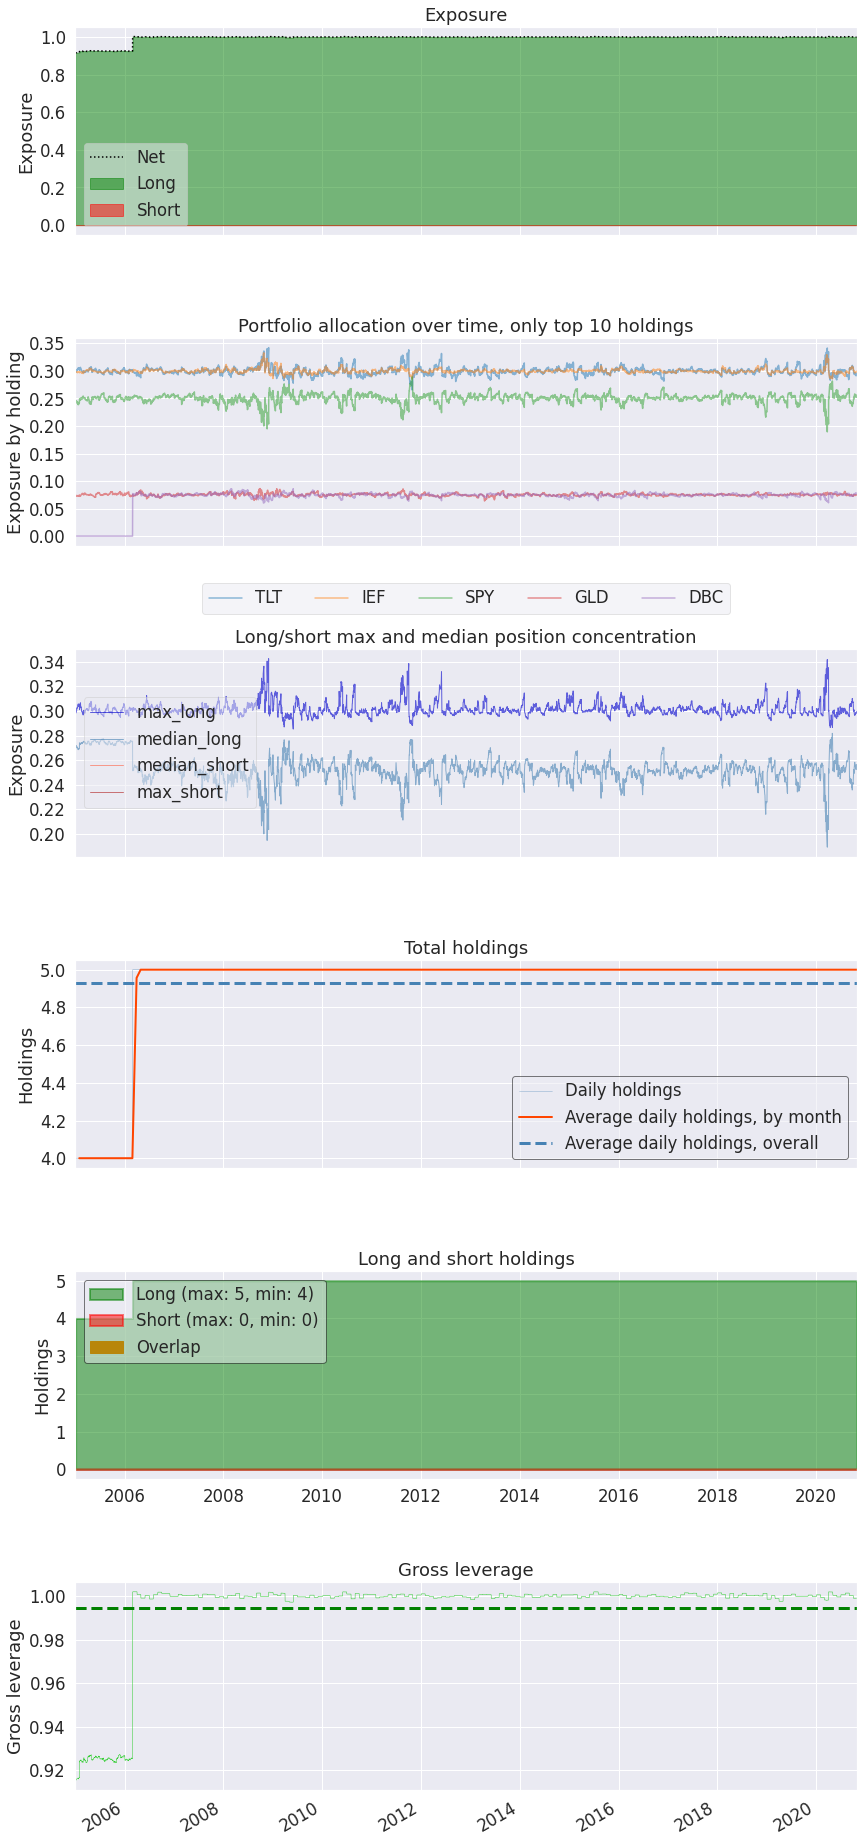

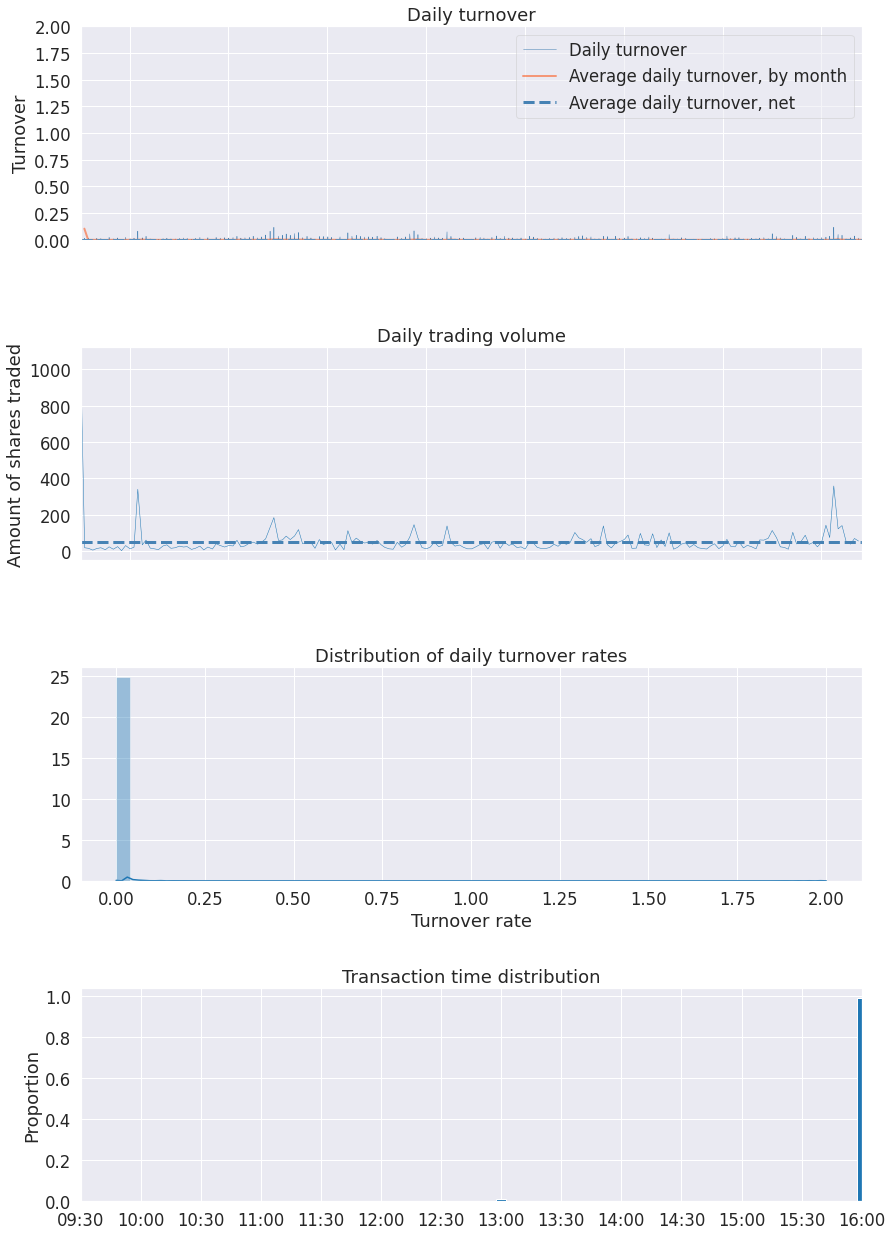

In [7]:
# Run the tear sheet analysis
analyze(result, bench_series)